# Regresión sobre una función polinomial

[Tarea 1]
1.   El objetivo es seleccionar la función base polinomial y usar mínimos cuadrados ordinarios para aprender el peso apropiado de la línea que mejor se ajuste a los datos.
2.   Graficar los ajustes con diferentes grados: 1, 3, 4, 6, 12, 18, 20.

3. Explicar y discutir el efecto de la función de costo.

In [80]:
import numpy as np
import scipy.sparse as sp
from math import sqrt
import matplotlib.pyplot as plt

## Conjunto de datos
Ejemplo de [PMTK3](https://github.com/probml/pmtk3).

In [81]:
X_ent = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
               11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0])
y_ent = np.array([3.10341864, -0.36949342, -4.20684311, -5.61381536,
                    -4.09482862, -3.23548442, -2.12902581, -7.28955698,
                    -2.8821206, -8.44323436, -5.9491123, -4.77948529,
                    -2.34705651, -3.11360479, 0.58915552, 3.66236699,
                    3.14385906, 11.92541392, 12.06829608, 13.37635698, 14.84302011])
n_ent = X_ent.shape[0]

X_valid = np.array([2.2, 2.7, 8.6, 9.5, 10.4, 10.5, 11.4, 14.9, 17.4, 19.3])
y_valid = np.array([-4.87830149, -2.22417664, -4.78937076, -5.39555669,
                    -1.89941084, -4.39873376, -2.74141712, 0.86251019,
                    8.2396395, 13.25506972])
n_valid = X_valid.shape[0]

X_rango = np.linspace(0, 20, 10000) # para graficar

Graficamos nuestros datos

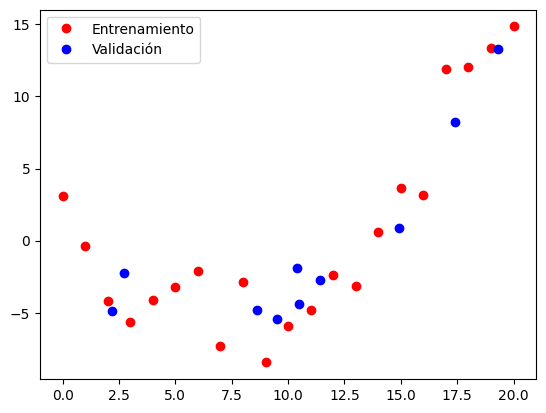

In [82]:
train_plot = plt.plot(X_ent, y_ent, 'ro', label = 'Entrenamiento')
valid_plot = plt.plot(X_valid, y_valid, 'bo', label = u'Validación')
plt.legend()
plt.show()

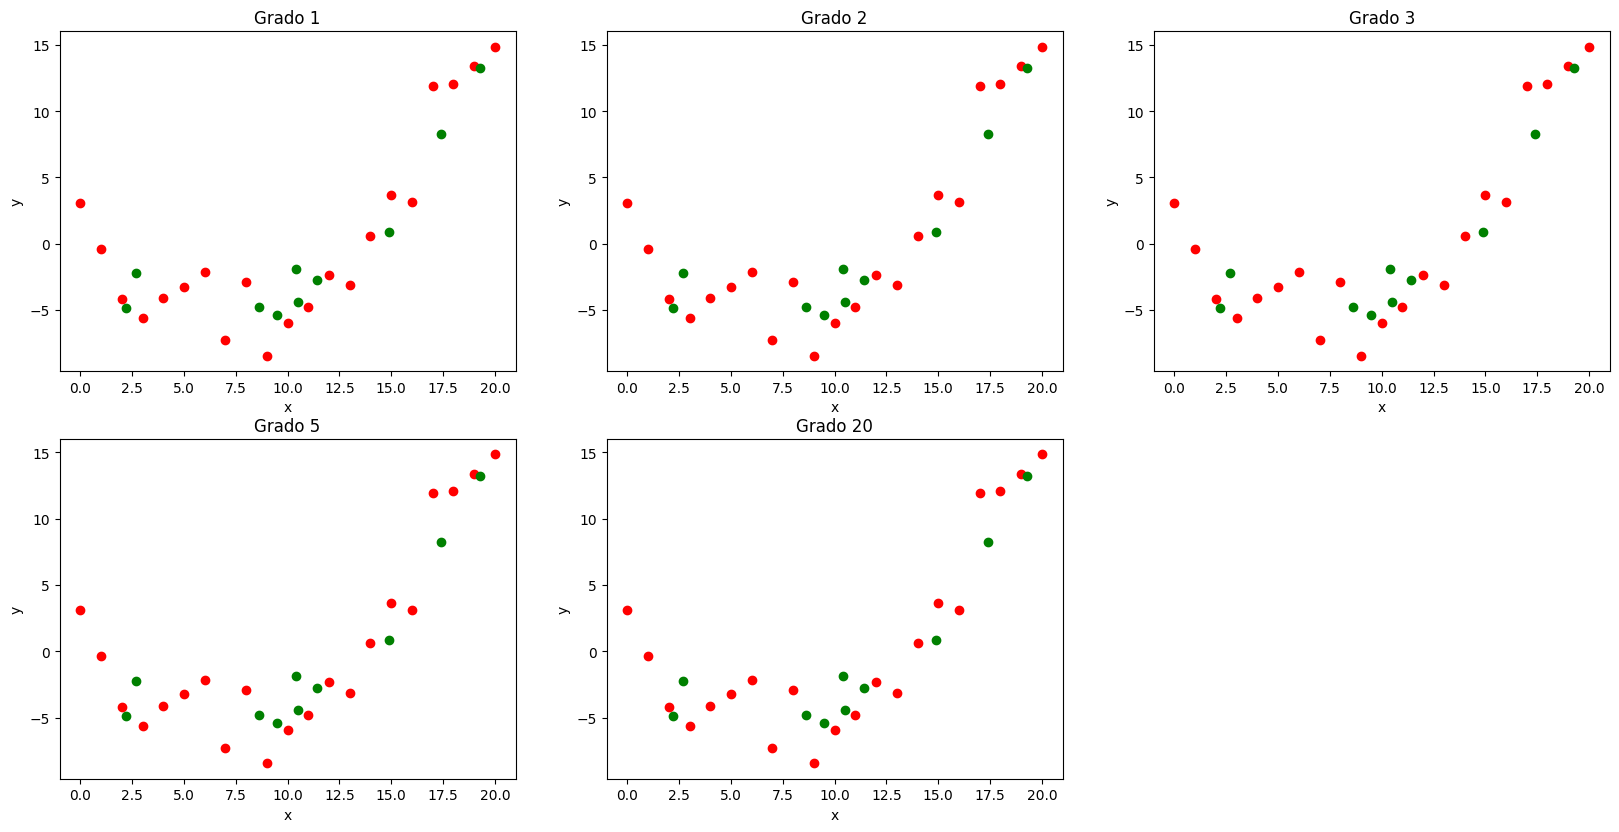

In [83]:
grados = np.array([1, 2, 3, 5, 20])
plt.figure(figsize=(20,15))
for i, grado in enumerate(grados):
  plt.subplot(3, 3, i + 1)
  plt.plot(X_ent, y_ent, 'ro', label='Datos de entrenamiento')
  plt.plot(X_valid, y_valid, 'go', label='Datos de validación')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Grado ' + str(grado))
plt.show()

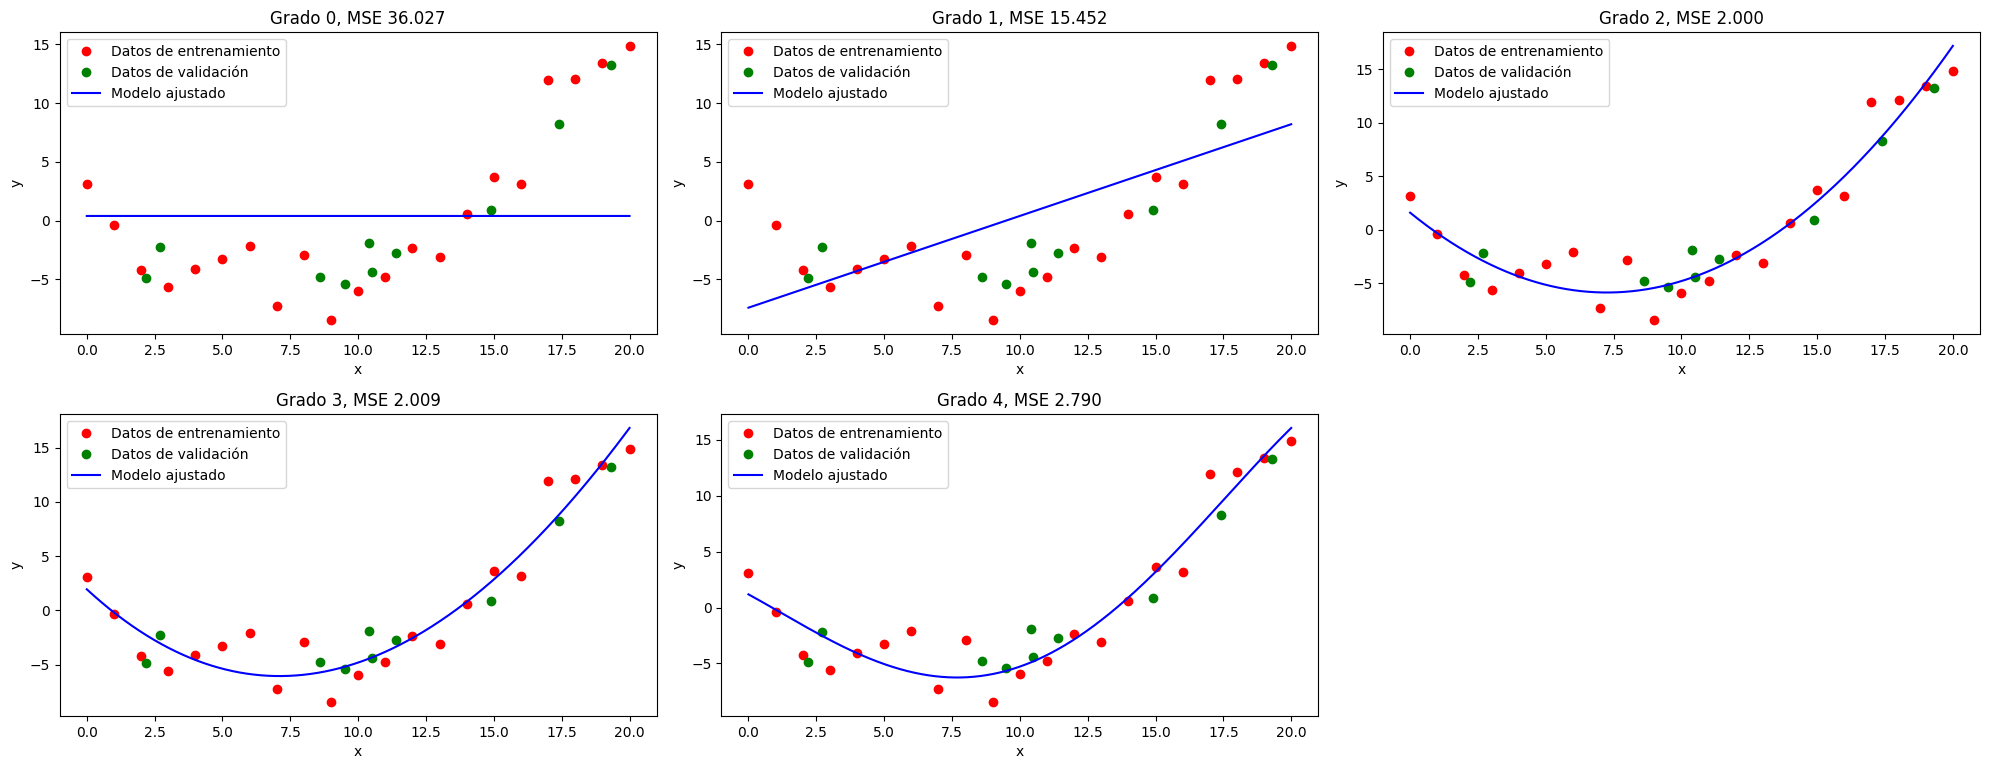

In [84]:
def calculate_thetas(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

def calculate_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

grades = range(len(grados))

plt.figure(figsize=(20, 15))

for grade in grades:
    X_train_stacked = np.column_stack([X_ent ** j for j in range(grade + 1)])
    X_valid_stacked = np.column_stack([X_valid ** j for j in range(grade + 1)])
    X_rango_stacked = np.column_stack([X_rango ** j for j in range(grade + 1)])

    thetas = calculate_thetas(X_train_stacked, y_ent)

    y_pred = X_rango_stacked @ thetas

    mse = calculate_mse(y_valid, X_valid_stacked @ thetas)

    plt.subplot(4, 3, grade + 1)
    plt.plot(X_ent, y_ent, 'ro', label='Datos de entrenamiento')
    plt.plot(X_valid, y_valid, 'go', label='Datos de validación')
    plt.plot(X_rango, y_pred, 'b', label='Modelo ajustado')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Grado {grade}, MSE {mse:.3f}')
    plt.legend()

plt.tight_layout()
plt.show()

# Implementación de la factorización QR
## Truco cortesía de David

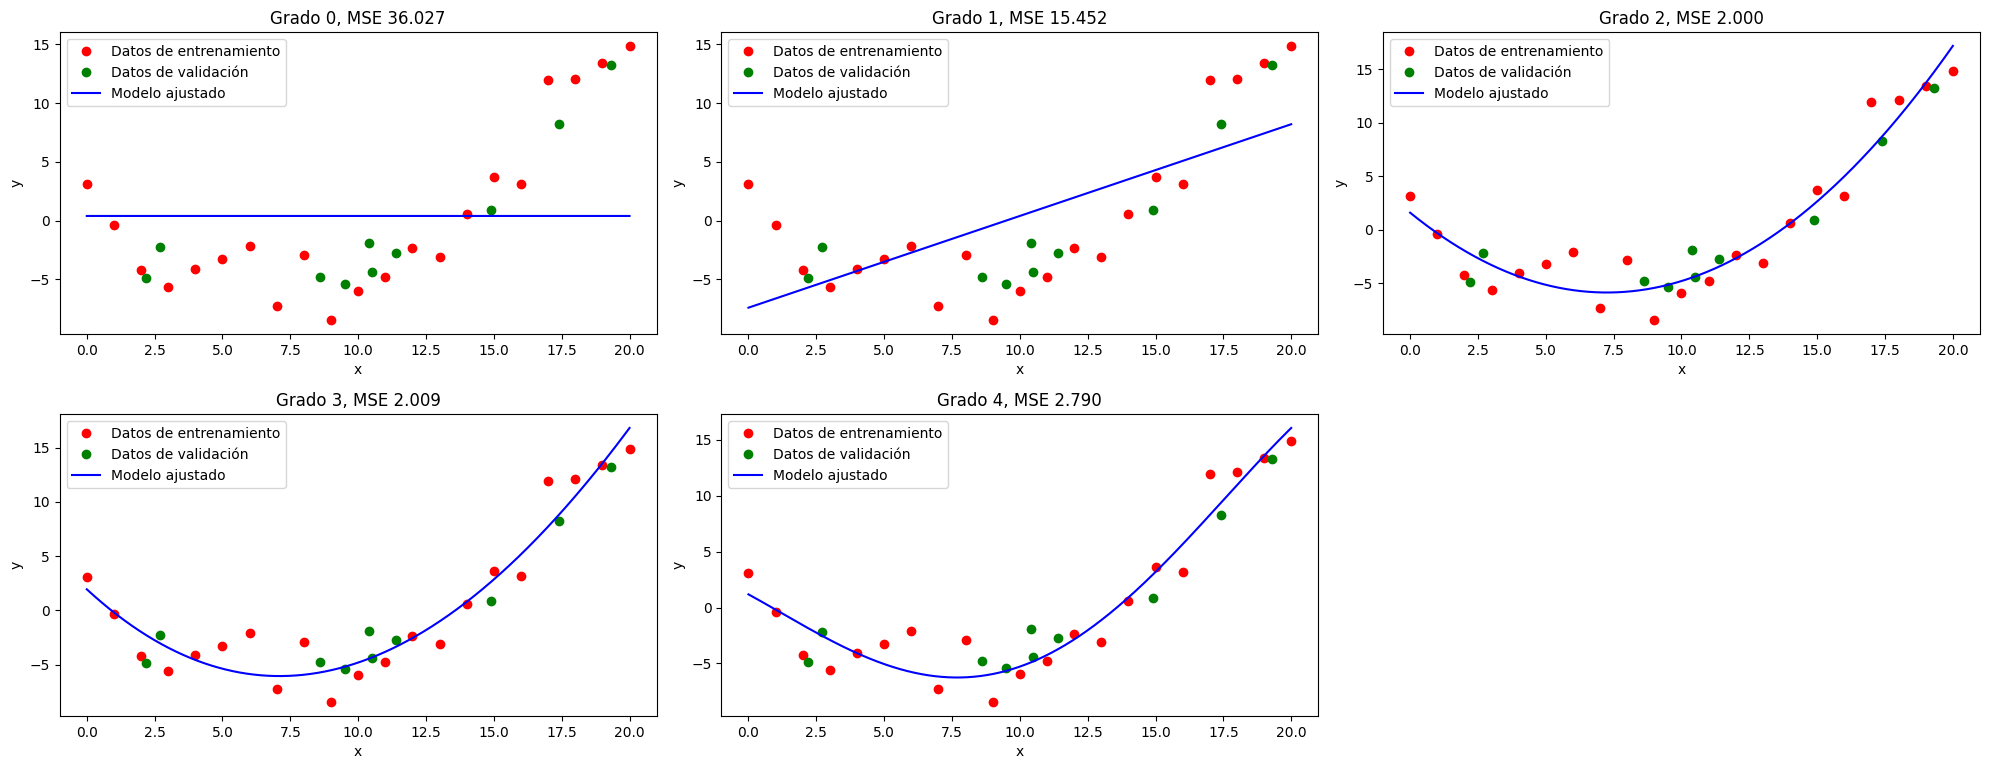

In [85]:
# UTILIZANDO LA IMPLEMENTACIÓN DE QR #

def calculate_thetas_QR(X, y):
    Q, R = np.linalg.qr(X)
    return np.linalg.solve(R, Q.T @ y)

grades = range(len(grades))

plt.figure(figsize=(20, 15))
errors = []

for grade in grades:
    plt.subplot(4, 3, grade + 1)

    X_train_stacked = np.column_stack([X_ent ** j for j in range(grade + 1)])
    X_valid_stacked = np.column_stack([X_valid ** j for j in range(grade + 1)])
    X_rango_stacked = np.column_stack([X_rango ** j for j in range(grade + 1)])

    thetas = calculate_thetas_QR(X_train_stacked, y_ent)

    y_pred = X_rango_stacked @ thetas

    mse = np.mean((y_valid - X_valid_stacked @ thetas) ** 2)
    errors.append(mse)

    plt.plot(X_ent, y_ent, 'ro', label='Datos de entrenamiento')
    plt.plot(X_valid, y_valid, 'go', label='Datos de validación')
    plt.plot(X_rango, y_pred, 'b', label='Modelo ajustado')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Grado {grade}, MSE {mse:.3f}')
    plt.legend()

plt.tight_layout()
plt.show()

# Descenso de Gradiante

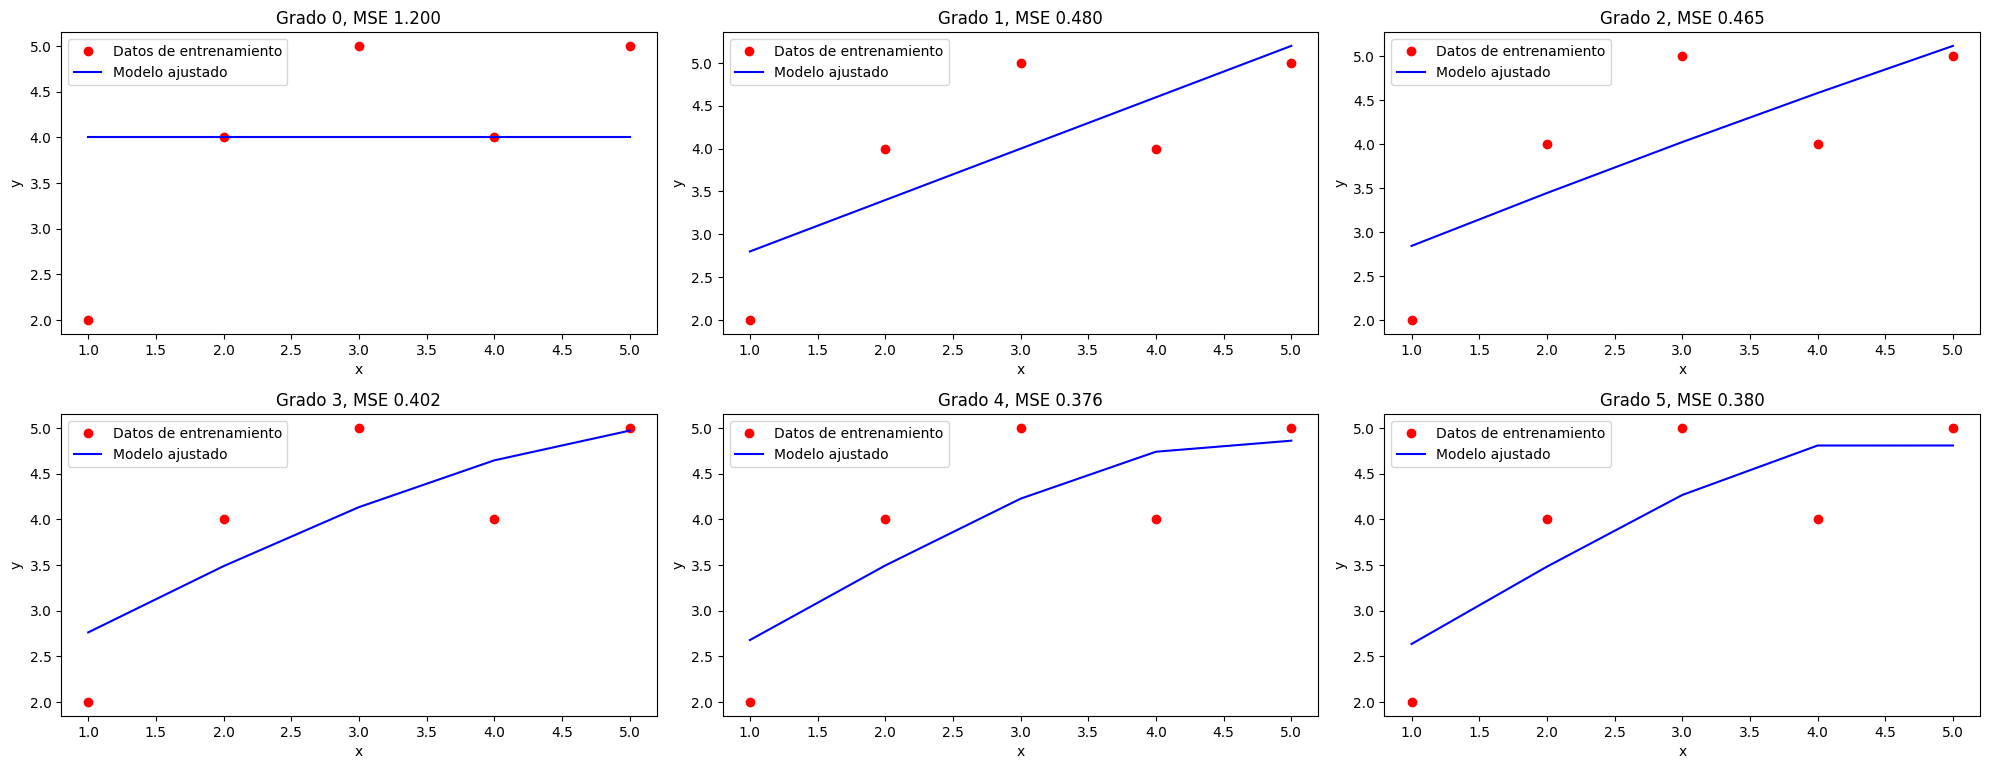

In [86]:
# Función para transformar X
def transform(X, degree):
    X_transform = np.ones((X.shape[0], 1))

    for j in range(1, degree + 1):
        x_pow = np.power(X, j)
        X_transform = np.append(X_transform, x_pow.reshape(-1, 1), axis=1)

    return X_transform

# Función para normalizar X_transform
def normalize(X_transform):
    X_transform[:, 1:] = (X_transform[:, 1:] - np.mean(X_transform[:, 1:], axis=0)) / np.std(X_transform[:, 1:], axis=0)
    return X_transform

# Función para entrenar el modelo usando descenso del gradiente
def train_model(X, Y, degree, learning_rate, iterations):
    m = len(X)
    W = np.zeros(degree + 1)
    X_transform = transform(X, degree)
    X_normalize = normalize(X_transform)

    for i in range(iterations):
        h = np.dot(X_normalize, W)
        error = h - Y
        gradient = (2 / m) * np.dot(X_normalize.T, error)
        W -= learning_rate * gradient

    return W

# Función para predecir
def predict(X, W, degree):
    X_transform = transform(X, degree)
    X_normalize = normalize(X_transform)
    return np.dot(X_normalize, W)

# Datos de entrenamiento
X_ent = np.array([1, 2, 3, 4, 5])
y_ent = np.array([2, 4, 5, 4, 5])

# Lista para almacenar los errores de ajuste
errors = []

# Grados de polinomio a considerar
grades = range(6)  # Cambiar el rango según sea necesario

plt.figure(figsize=(20, 15))

for grade in grades:
    W = train_model(X_ent, y_ent, grade, learning_rate=0.01, iterations=500)
    Y_pred = predict(X_ent, W, grade)
    mse = np.mean((y_ent - Y_pred) ** 2)
    errors.append(mse)

    plt.subplot(4, 3, grade + 1)
    plt.plot(X_ent, y_ent, 'ro', label='Datos de entrenamiento')
    plt.plot(X_ent, Y_pred, 'b', label='Modelo ajustado')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Grado {grade}, MSE {mse:.3f}')
    plt.legend()

plt.tight_layout()
plt.show()

# Regularización

## Explicación:
\textbf{Costo de la Regresión Lineal con Regularización Ridge (L2):}
El costo de la regresión lineal con regularización Ridge se define como:

$$J(\mathbf{w}) = \text{MSE}(\mathbf{w}) + \lambda \sum_{i=1}^{n} w_i^2$$

Donde:

- $J(\mathbf{w})$ es la función de costo regularizada.
- $ \text{MSE}(\mathbf{w})$ es el error cuadrático medio (MSE) de la regresión lineal sin regularización, que mide la diferencia entre las predicciones y los valores reales.
- $\lambda$ (lambda) es el parámetro de regularización, que controla la fuerza de la regularización. Es un hiperparámetro que puedes ajustar. Un valor mayor de $\lambda$ aumenta la regularización.
- $\sum_{i=1}^{n} w_i^2$ es la suma de los cuadrados de los coeficientes del modelo (excepto el término de sesgo $w_0 $.

\textbf{Objetivo de la Regularización Ridge:}
El objetivo de la regularización Ridge es minimizar el costo $ J(\mathbf{w}) $, lo que significa encontrar los coeficientes $\mathbf{w}$ que se ajusten bien a los datos (según el término $ \text{MSE}(\mathbf{w}) $ mientras mantienen pequeños los valores de los coeficientes (según el término de regularización $ \lambda \sum_{i=1}^{n} w_i^2 $.

\textbf{Impacto de la Regularización Ridge:}
- La regularización Ridge penaliza los coeficientes grandes, lo que ayuda a prevenir el sobreajuste del modelo.
- A medida que $ \lambda $ aumenta, el impacto de la regularización en la reducción de los coeficientes también aumenta, lo que lleva a un modelo más simple.

\textbf{Entrenamiento con Gradiente Descendente:}
Durante el entrenamiento del modelo, se utilizan métodos como el descenso de gradiente para encontrar los coeficientes $\mathbf{w}$ que minimizan el costo total $J(\mathbf{w})$.

\textbf{Derivada del Costo con Respecto a $w_i$ (Gradiente):}
La derivada del costo $ J(\mathbf{w}) $ con respecto a $w_i$ (gradiente) tiene en cuenta tanto el término de MSE como el término de regularización Ridge:
$$\frac{\partial J(\mathbf{w})}{\partial w_i} = \frac{1}{m} \sum_{j=1}^{m} (h_{\mathbf{w}}(\mathbf{x}^{(j)}) - y^{(j)})x_i^{(j)} + 2 \lambda w_i$$

Donde:
- $h_{\mathbf{w}}(\mathbf{x}^{(j)}) $ es la predicción del modelo para el ejemplo $\mathbf{x}^{(j)}$.
- $y^{(j)}$ es el valor real para el ejemplo $ \mathbf{x}^{(j)}$.
- $x_i^{(j)}$ es el valor de la característica $ i $ en el ejemplo $ \mathbf{x}^{(j)}$.


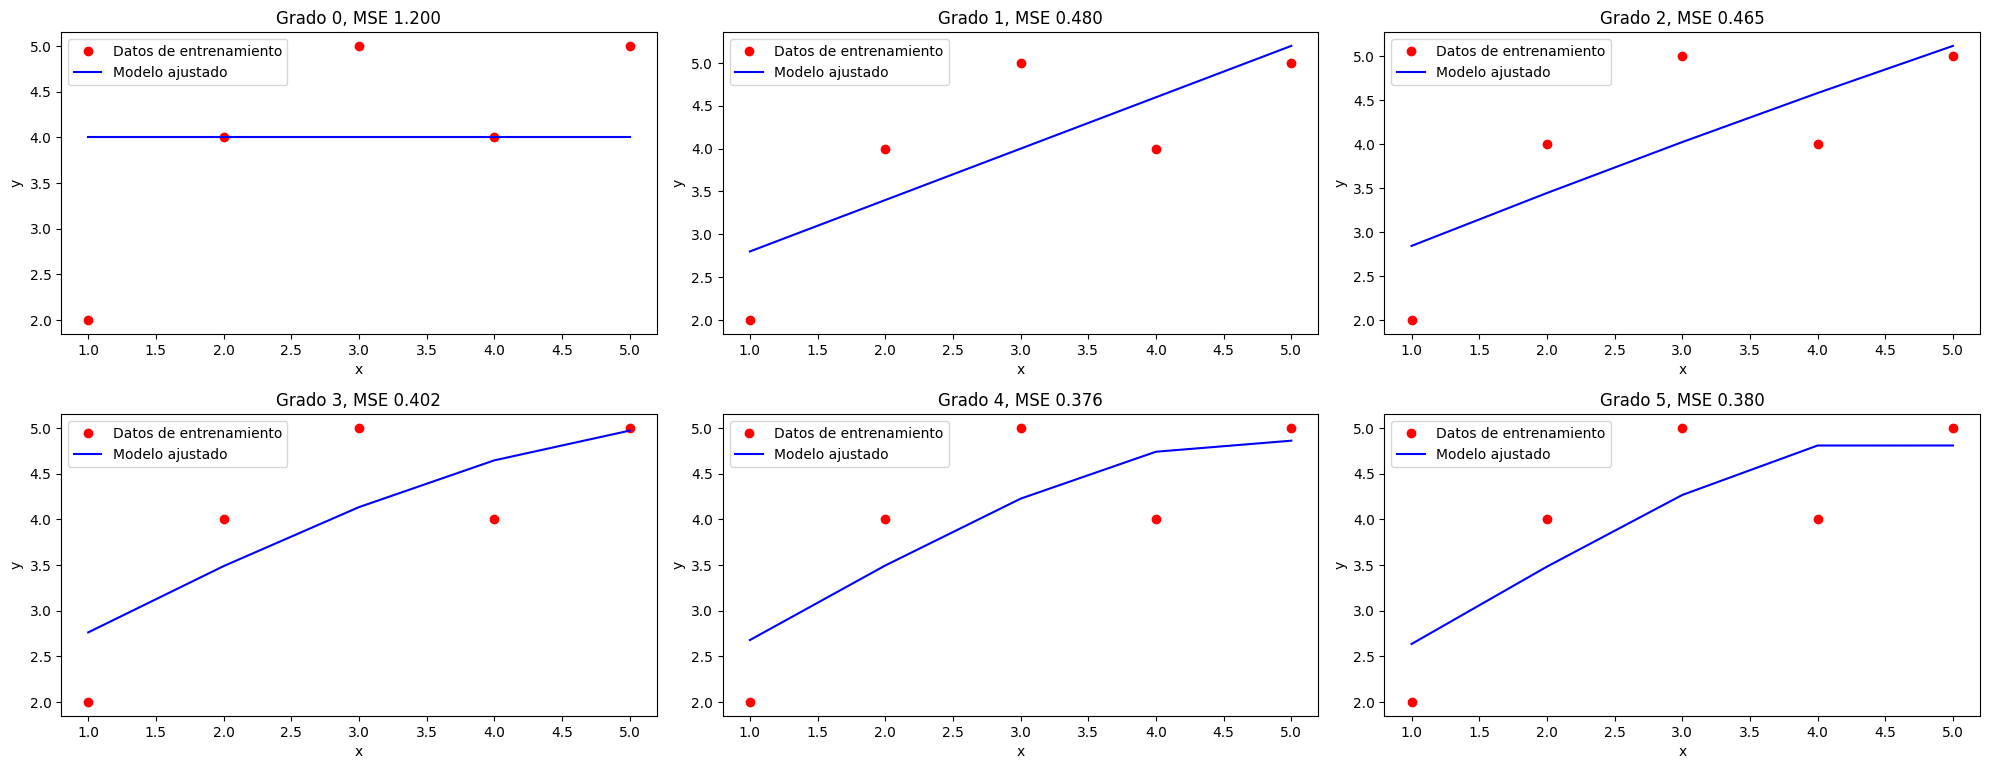

In [87]:
# Función para transformar X
def transform(X, degree):
    X_transform = np.ones((X.shape[0], 1))

    for j in range(1, degree + 1):
        x_pow = np.power(X, j)
        X_transform = np.append(X_transform, x_pow.reshape(-1, 1), axis=1)

    return X_transform

# Función para normalizar X_transform
def normalize(X_transform):
    X_transform[:, 1:] = (X_transform[:, 1:] - np.mean(X_transform[:, 1:], axis=0)) / np.std(X_transform[:, 1:], axis=0)
    return X_transform

# Función para entrenar el modelo usando descenso del gradiente
def train_model(X, Y, degree, learning_rate, iterations):
    m = len(X)
    W = np.zeros(degree + 1)
    X_transform = transform(X, degree)
    X_normalize = normalize(X_transform)

    for i in range(iterations):
        h = np.dot(X_normalize, W)
        error = h - Y
        gradient = (2 / m) * np.dot(X_normalize.T, error)
        W -= learning_rate * gradient

    return W

# Función para predecir
def predict(X, W, degree):
    X_transform = transform(X, degree)
    X_normalize = normalize(X_transform)
    return np.dot(X_normalize, W)

# Lista para almacenar los errores de ajuste
errors = []

# Grados de polinomio a considerar
grades = range(6)  # Cambiar el rango según sea necesario

plt.figure(figsize=(20, 15))

for grade in grades:
    W = train_model(X_ent, y_ent, grade, learning_rate=0.01, iterations=500)
    Y_pred = predict(X_ent, W, grade)
    mse = np.mean((y_ent - Y_pred) ** 2)
    errors.append(mse)

    plt.subplot(4, 3, grade + 1)
    plt.plot(X_ent, y_ent, 'ro', label='Datos de entrenamiento')
    plt.plot(X_ent, Y_pred, 'b', label='Modelo ajustado')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Grado {grade}, MSE {mse:.3f}')
    plt.legend()

plt.tight_layout()
plt.show()